In [1]:
import networkx as nx
g= nx.convert_node_labels_to_integers(nx.read_graphml("g_cdmx_infomap.graphml"))
g_susana= nx.convert_node_labels_to_integers(nx.read_graphml("g_susana.graphml"))

In [52]:
def funcion_SEIR (g, gamma, tau, R0, Rt, min_ei_attribute, max_ei_attribute, min_ir_attribute, max_ir_attribute, recuperados_totales, infectados_totales, poblacion_total):
    import networkx as nx
    import matplotlib.pyplot as plt
    import EoN
    from matplotlib import rc
    import scipy
    import numpy as np
    import random
    import pandas as pd
    import numpy as np
    from collections import defaultdict
    from pathlib import Path
    
    def funcion_preparadora(nw):
        nw=nw.copy()
        #stochastic transition E-I
        ei_node_attribut={node:random.uniform(a=min_ei_attribute, b=max_ei_attribute) for node in nw.nodes()}
        #stochastic transition I-R
        #will multiply recovery rate for some factor so it is between 14 and 28 days
        ir_node_attribute={node:random.uniform(a=min_ir_attribute,b=max_ir_attribute) for node in nw.nodes()}
        #Transmission weight -varies for each pair of interactions (some contacts are very transmisibles other are not so)
        edge_attribute_dict= {edge:0.5+random.random()for edge in nw.edges()}
        nx.set_node_attributes(nw, values=ei_node_attribut, name='expose2infect_weight')
        nx.set_node_attributes(nw, values=ir_node_attribute, name='infect2recover_weight')
        nx.set_edge_attributes(nw, values=edge_attribute_dict, name='transmission_weight')
    
        return(nw)
    
    ei_rate=tau
    ir_rate=gamma
    transmission_rate= 1/(1/gamma)*Rt
    
    poblacion_escalada= len(g.nodes())
    
    recuperados_escalados= round(recuperados_totales*poblacion_escalada/poblacion_total)
    infectados_escalados= round(infectados_totales*poblacion_escalada/poblacion_total)
    
    IC= defaultdict(lambda:'S')
    for node in range(infectados_escalados-1):
        IC[node]='I'
    
    for node in range(infectados_escalados, infectados_escalados+recuperados_escalados):
        IC[node]='R'
    
    return_statuses=('S','E','I','R')
    
    H=nx.DiGraph()
    H.add_node('S')
    H.add_edge('E','I', rate=tau, weight_label='expose2infect_weight')
    H.add_edge('I','R', rate=gamma, weight_label='infect2recover_weight')
    
    J=nx.DiGraph()
    J.add_edge(('I','S'),('I','E'), rate=transmission_rate, weight_label='transmission_weight')
    
    np.random.seed(725)
    random.seed(725)
    prep_g=funcion_preparadora(g)
    mod_nuloAbs=EoN.Gillespie_simple_contagion(G=prep_g,
                                          spontaneous_transition_graph=H,
                                          nbr_induced_transition_graph=J,
                                          IC=IC,
                                          return_statuses=return_statuses,
                                          return_full_data=True,
                                          tmax=1000)
    
    predata=mod_nuloAbs.summary()[1]
    predata["t"]=mod_nuloAbs.summary()[0]
    df=pd.DataFrame(predata)
    df = df.assign(I_pc=100*df['I']/poblacion_escalada)
    return(df.plot(x="t", y="I_pc"), df)

(<AxesSubplot:xlabel='t'>,
          S  E    I     R           t      I_pc
 0     6953  0  199    64    0.000000  2.757761
 1     6953  0  198    65    0.090539  2.743902
 2     6952  1  198    65    0.114682  2.743902
 3     6952  1  197    66    0.164145  2.730044
 4     6952  1  196    67    0.178575  2.716186
 ...    ... ..  ...   ...         ...       ...
 5709  5115  0    4  2097  197.986927  0.055432
 5710  5115  0    3  2098  211.499211  0.041574
 5711  5115  0    2  2099  216.261164  0.027716
 5712  5115  0    1  2100  228.931121  0.013858
 5713  5115  0    0  2101  234.724485  0.000000
 
 [5714 rows x 6 columns])

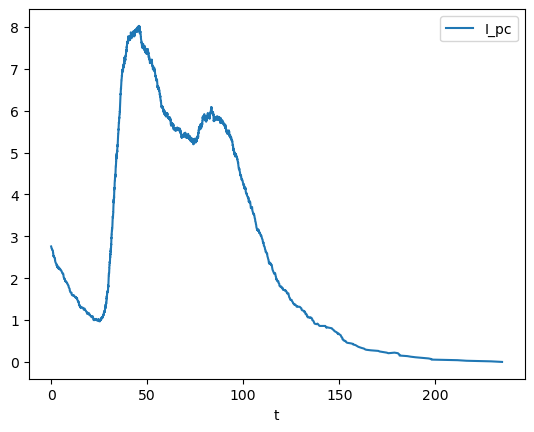

In [54]:
funcion_SEIR(g_susana, 
             gamma=1/14, 
             tau=1/5.3, 
             R0=2.5, 
             Rt=1.18,  
             min_ei_attribute=0.5,  
             min_ir_attribute=0.5,  
             max_ir_attribute=1, 
             max_ei_attribute=1.5, 
             recuperados_totales=80000, 
             infectados_totales=250000, 
             poblacion_total=9000000)

In [57]:
def funcion_SEIRD (g, gamma, tau, R0, Rt,disease_rate, min_ei_attribute, max_ei_attribute, min_ir_attribute, max_ir_attribute, recuperados_totales, infectados_totales, poblacion_total):
    import networkx as nx
    import matplotlib.pyplot as plt
    import EoN
    from matplotlib import rc
    import scipy
    import numpy as np
    import random
    import pandas as pd
    import numpy as np
    from collections import defaultdict
    from pathlib import Path
    
    def funcion_preparadora(nw):
        nw=nw.copy()
        #stochastic transition E-I
        ei_node_attribut={node:random.uniform(a=min_ei_attribute, b=max_ei_attribute) for node in nw.nodes()}
        #stochastic transition I-R
        #will multiply recovery rate for some factor so it is between 14 and 28 days
        ir_node_attribute={node:random.uniform(a=min_ir_attribute,b=max_ir_attribute) for node in nw.nodes()}
        rd_node_attribute={node:random.uniform(a=0,b=0.5) for node in nw.nodes()}
        #Transmission weight -varies for each pair of interactions (some contacts are very transmisibles other are not so)
        edge_attribute_dict= {edge:0.5+random.random()for edge in nw.edges()}
        nx.set_node_attributes(nw, values=ei_node_attribut, name='expose2infect_weight')
        nx.set_node_attributes(nw, values=ir_node_attribute, name='infect2recover_weight')
        nx.set_node_attributes(nw, values=rd_node_attribute, name='recover2death_weight')
        nx.set_edge_attributes(nw, values=edge_attribute_dict, name='transmission_weight')
    
        return(nw)
    
    ei_rate=tau
    ir_rate=gamma
    transmission_rate= 1/(1/gamma)*Rt
    rd_rate=disease_rate
    
    poblacion_escalada= len(g.nodes())
    
    recuperados_escalados= round(recuperados_totales*poblacion_escalada/poblacion_total)
    infectados_escalados= round(infectados_totales*poblacion_escalada/poblacion_total)
    
    IC= defaultdict(lambda:'S')
    for node in range(infectados_escalados-1):
        IC[node]='I'
    
    for node in range(infectados_escalados, infectados_escalados+recuperados_escalados):
        IC[node]='R'
    
    return_statuses=('S','E','I','R','D')
    
    H=nx.DiGraph()
    H.add_node('S')
    H.add_edge('E','I', rate=tau, weight_label='expose2infect_weight')
    H.add_edge('I','R', rate=gamma, weight_label='infect2recover_weight')
    H.add_edge('R','D', rate=disease_rate, weight_label='recover2death_weight')
    
    J=nx.DiGraph()
    J.add_edge(('I','S'),('I','E'), rate=transmission_rate, weight_label='transmission_weight')
    
    np.random.seed(725)
    random.seed(725)
    prep_g=funcion_preparadora(g)
    mod_nuloAbs=EoN.Gillespie_simple_contagion(G=prep_g,
                                          spontaneous_transition_graph=H,
                                          nbr_induced_transition_graph=J,
                                          IC=IC,
                                          return_statuses=return_statuses,
                                          return_full_data=True,
                                          tmax=1000)
    
    predata=mod_nuloAbs.summary()[1]
    predata["t"]=mod_nuloAbs.summary()[0]
    df=pd.DataFrame(predata)
    df = df.assign(I_pc=100*df['I']/poblacion_escalada)
    return(df.plot(x="t", y="I_pc"), df)

(<AxesSubplot:xlabel='t'>,
          S  E   I     R    D           t      I_pc
 0     7073  0  79    64    0    0.000000  1.094789
 1     7073  0  78    65    0    0.133940  1.080931
 2     7073  0  77    66    0    0.261734  1.067073
 3     7073  0  76    67    0    0.437097  1.053215
 4     7072  1  76    67    0    0.646929  1.053215
 ...    ... ..  ..   ...  ...         ...       ...
 5261  5391  0   0  1689  136  966.213204  0.000000
 5262  5391  0   0  1688  137  977.967421  0.000000
 5263  5391  0   0  1687  138  982.857470  0.000000
 5264  5391  0   0  1686  139  985.438513  0.000000
 5265  5391  0   0  1685  140  998.422298  0.000000
 
 [5266 rows x 7 columns])

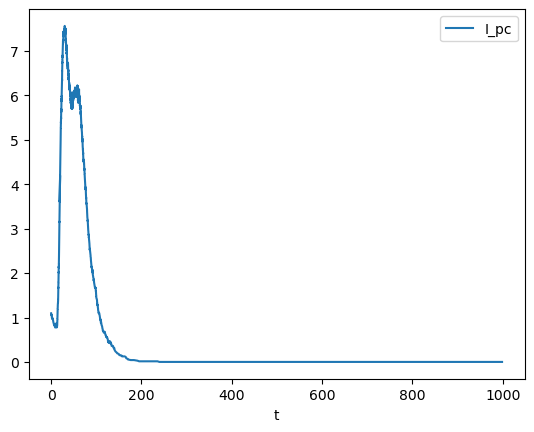

In [58]:
funcion_SEIRD(g_susana, 
              gamma=1/14, 
              tau=1/5.3, 
              R0=2.5, 
              Rt=1.18, 
              disease_rate=0.0003, 
              min_ei_attribute=0.5,  
              min_ir_attribute=0.5,  
              max_ir_attribute=1, 
              max_ei_attribute=1.5, 
              recuperados_totales=80000, 
              infectados_totales=100000, 
              poblacion_total=9000000)

In [60]:
def funcion_SEIRV (g, gamma, tau, R0, Rt, min_ei_attribute, max_ei_attribute, min_ir_attribute, max_ir_attribute, recuperados_totales, infectados_totales, vacunados_totales, poblacion_total):
    import networkx as nx
    import matplotlib.pyplot as plt
    import EoN
    from matplotlib import rc
    import scipy
    import numpy as np
    import random
    import pandas as pd
    import numpy as np
    from collections import defaultdict
    from pathlib import Path
    
    def funcion_preparadora(nw):
        nw=nw.copy()
        #stochastic transition E-I
        ei_node_attribut={node:random.uniform(a=min_ei_attribute, b=max_ei_attribute) for node in nw.nodes()}
        #stochastic transition I-R
        #will multiply recovery rate for some factor so it is between 14 and 28 days
        ir_node_attribute={node:random.uniform(a=min_ir_attribute,b=max_ir_attribute) for node in nw.nodes()}
        vi_node_attribute={node:0 for node in nw.nodes()}     
        #Transmission weight -varies for each pair of interactions (some contacts are very transmisibles other are not so)
        edge_attribute_dict= {edge:0.5+random.random()for edge in nw.edges()}
        nx.set_node_attributes(nw, values=ei_node_attribut, name='expose2infect_weight')
        nx.set_node_attributes(nw, values=ir_node_attribute, name='infect2recover_weight')
        nx.set_node_attributes(nw, values=vi_node_attribute, name='vaccinat2infect_weight')
        nx.set_edge_attributes(nw, values=edge_attribute_dict, name='transmission_weight')
    
        return(nw)
    
    ei_rate=tau
    ir_rate=gamma
    transmission_rate= 1/(1/gamma)*Rt
    
    poblacion_escalada= len(g.nodes())
    
    recuperados_escalados= round(recuperados_totales*poblacion_escalada/poblacion_total)
    infectados_escalados= round(infectados_totales*poblacion_escalada/poblacion_total)
    vacunados_escalados= round(vacunados_totales*poblacion_escalada/poblacion_total)
    
    IC= defaultdict(lambda:'S')
    for node in range(infectados_escalados-1):
        IC[node]='I'
    
    for node in range(infectados_escalados, infectados_escalados+recuperados_escalados):
        IC[node]='R'
        
    for node in range(infectados_escalados+recuperados_escalados, infectados_escalados+recuperados_escalados+vacunados_escalados):
        IC[node]='V'
    
    return_statuses=('S','E','I','R','V')
    
    H=nx.DiGraph()
    H.add_node('S')
    H.add_edge('E','I', rate=tau, weight_label='expose2infect_weight')
    H.add_edge('I','R', rate=gamma, weight_label='infect2recover_weight')
    H.add_edge('V','I', rate=0, weight_label='vaccinat2infect_weight')
    
    J=nx.DiGraph()
    J.add_edge(('I','S'),('I','E'), rate=transmission_rate, weight_label='transmission_weight')
    
    np.random.seed(725)
    random.seed(725)
    prep_g=funcion_preparadora(g)
    mod_nuloAbs=EoN.Gillespie_simple_contagion(G=prep_g,
                                          spontaneous_transition_graph=H,
                                          nbr_induced_transition_graph=J,
                                          IC=IC,
                                          return_statuses=return_statuses,
                                          return_full_data=True,
                                          tmax=1000)
    
    predata=mod_nuloAbs.summary()[1]
    predata["t"]=mod_nuloAbs.summary()[0]
    df=pd.DataFrame(predata)
    df = df.assign(I_pc=100*df['I']/poblacion_escalada)
    return(df.plot(x="t", y="I_pc"), df)

(<AxesSubplot:xlabel='t'>,
          S  E    I     R    V           t      I_pc
 0     6913  0  119    64  120    0.000000  1.649113
 1     6913  0  118    65  120    0.154947  1.635255
 2     6913  0  117    66  120    0.598708  1.621397
 3     6913  0  116    67  120    1.372008  1.607539
 4     6913  0  115    68  120    1.416109  1.593681
 ...    ... ..  ...   ...  ...         ...       ...
 5524  5110  0    4  1982  120  171.158107  0.055432
 5525  5110  0    3  1983  120  176.469840  0.041574
 5526  5110  0    2  1984  120  187.572506  0.027716
 5527  5110  0    1  1985  120  188.370859  0.013858
 5528  5110  0    0  1986  120  212.244818  0.000000
 
 [5529 rows x 7 columns])

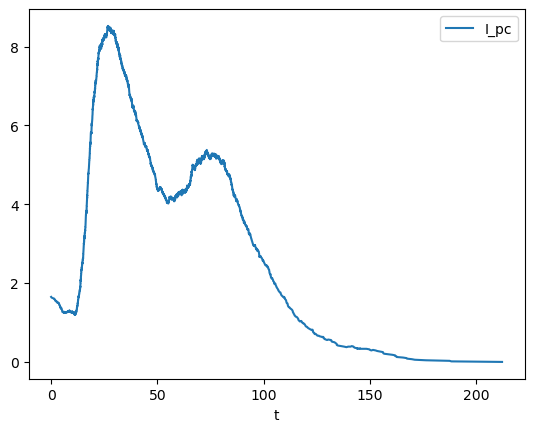

In [61]:
funcion_SEIRV(g_susana, 
              gamma=1/14, 
              tau=1/5.3, 
              R0=2.5, 
              Rt=1.18, 
              min_ei_attribute=0.5,  
              min_ir_attribute=0.5,
              max_ir_attribute=1, 
              max_ei_attribute=1.5, 
              recuperados_totales=80000, 
              infectados_totales=150000, 
              vacunados_totales=150000, 
              poblacion_total=9000000)